In [216]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import pandas as pd
import numpy as np
from collections import defaultdict

if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']

from pygents.aigents_api import tokenize_re, punct
from pygents.plot import plot_dict
from pygents.util import dictcount, dict_compress_with_loss, dictdict_div_dict, dictdict_mul_dictdict

from pygents.token import FreedomTokenizer, FreedomBasedTokenizer, LexiconIndexedTokenizer, model_compress_with_loss

import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

punct

'-_…–&•—$+\\/*#^@~‰`"“”„(){}[]<>,;:.!?'

In [217]:
# Dataset: Unclassified distortions (halilbabacan)
# Paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4582307
# Data: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main/raw
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/blob/main/raw/Cognitive_distortions.csv
    
binary_dataset_file_path = "./data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

In [218]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

Path to dataset files: /Users/akolonin/.cache/kagglehub/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset/versions/1


In [219]:
df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)l", value = np.nan)
df1

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
3522,Since then whenever my mother is out alone I b...,NaN,Distortion,NaN
3523,My family hate him but they didn’t met him at ...,NaN,Distortion,NaN
3524,However I am not happy at the least only half ...,NaN,Distortion,NaN
3525,Now I am at university my peers around me all ...,NaN,Distortion,NaN


In [220]:
df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 
df2

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [221]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,NaN,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN,NaN


In [222]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,NaN,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN,NaN


In [223]:
# Analyzing the frequency of words (tokens) for each cognitive distortion

punctuation = punct+' '

def count_dicts_from_texts(df, tokenizer, clean_punct=True):
    all_distortions = defaultdict(int)
    distortions_dicts = defaultdict(lambda: defaultdict(int))  # A separate dictionary is created for each distortion (distortion-token-token_frequency)
    all_tokens_dict = defaultdict(int)  # A general dictionary of all tokens
    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = (row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]).lower()
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
    
        dictcount(all_distortions,primary_distortion)
        if secondary_distortion:
            dictcount(all_distortions,secondary_distortion)
     
        # Text tokenization
        tokens = [t for t in tokenizer(text) if not (t in punctuation or t.isnumeric())] if clean_punct else tokenizer(text)
        
        # Remove stop words
        # filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
        filtered_tokens = tokens
    
        dictcount(all_tokens_dict, filtered_tokens)  # Increment the counter in the general dictionary
        dictcount(distortions_dicts[primary_distortion], filtered_tokens)  # Increment the counter for the corresponding primary distortion
        if secondary_distortion:
            dictcount(distortions_dicts[secondary_distortion], filtered_tokens) # Increment the counter for the corresponding secondary distortion (if present)
    return all_distortions, distortions_dicts, all_tokens_dict



9246


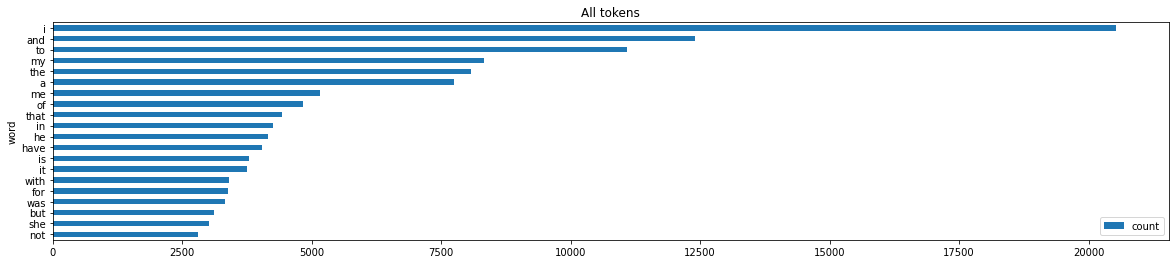

In [224]:
rdicts = count_dicts_from_texts(df3,tokenize_re)
print(len(rdicts[2]))

# Display a general graph for all tokens
plot_dict(
    rdicts[2],
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)


In [225]:
def has_punct(w):
    for c in w:
        if (not c in'-\'’') and (c in punct):
            return True
    return False

dic = rdicts[2]
print([key for key in dic if has_punct(key)])
#df = pd.DataFrame([(key, dic[key]) for key in dic if has_punct(key)],columns=['word','count'])
#df.sort_values('count',ascending=False,inplace=True)
#df[-20:]

['24/7', '17/18', '1/2', '50/50', '1:30', '4:11', '4:45', '6:30am', '8:29', '9:40', '6x/week', '2/3', '24/7now', '24/7am', '1.7', '1.5', '2.614', '3.25', '3.5', '7,5,2', '2.5', '1,000', '10,000', '9,\xa0', '4.0', '0,2', '24/7.am', '12,and']


In [226]:
def print_line(df,pats):
    for _, row in df.iterrows():
        text = (row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]).lower()
        match = 0
        for pat in pats:
            if pat in text:
                match += 1
        if match == len(pats):
            toks = tokenize_re(text)
            if len(pats) > 0:
            #if len(pats) > 1 or pats[0] in toks:
                print(text)
                print(toks)
                break


In [228]:
#just debugging
#print_line(df3,['current_problem'])


In [10]:
base = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)
model_compress_with_loss(base.model,0.0001)
test_tokenizer = FreedomBasedTokenizer(base,'ddf-','ddf+')
test_tokenizer.set_options(nlist = [1], threshold=0.4) # expected F1=0.99

def freedom_tokenizer(text):
    return test_tokenizer.tokenize(text)


In [11]:
gubr = FreedomTokenizer(name='data/models/gutenberg_brown_chars_7a',max_n=7,mode='chars',debug=False)
model_compress_with_loss(gubr.model,0.0001)
gubr_tokenizer = FreedomBasedTokenizer(gubr,'ddf-','ddf+')
gubr_tokenizer.set_options(nlist = [1], threshold=0.4) # expected F1=0.99

def freedom_gubr_tokenizer(text):
    return gubr_tokenizer.tokenize(text)

In [12]:
en_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_english.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
lex_tokenizer = LexiconIndexedTokenizer(lexicon=en_lex,sortmode=0,cased=True)
def lexicon_tokenizer(text):
    return [chunk.strip() for chunk in lex_tokenizer.tokenize(text)]

10937


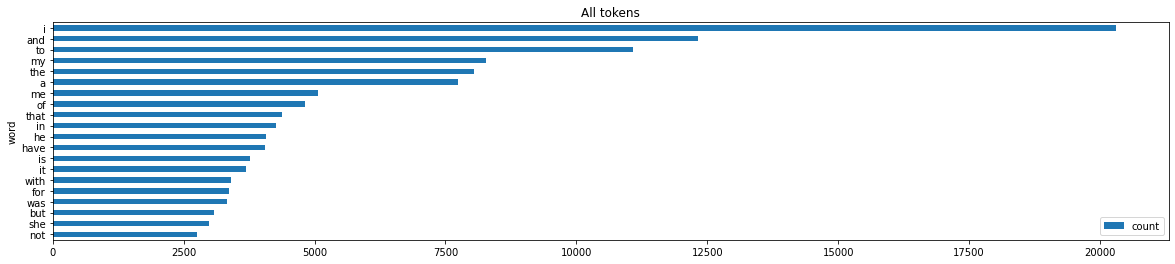

In [15]:
fdicts = count_dicts_from_texts(freedom_tokenizer)
print(len(fdicts[2]))

# Display a general graph for all tokens
plot_dict(
    fdicts[2],
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)

10938


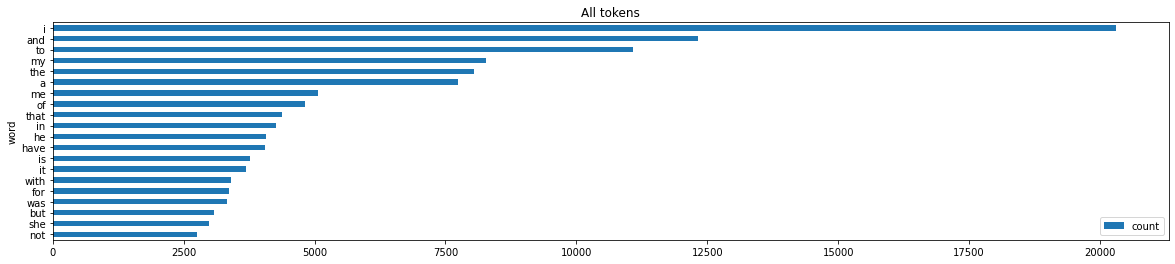

In [16]:
gdicts = count_dicts_from_texts(freedom_gubr_tokenizer)
print(len(gdicts[2]))

# Display a general graph for all tokens
plot_dict(
    gdicts[2],
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)

9109


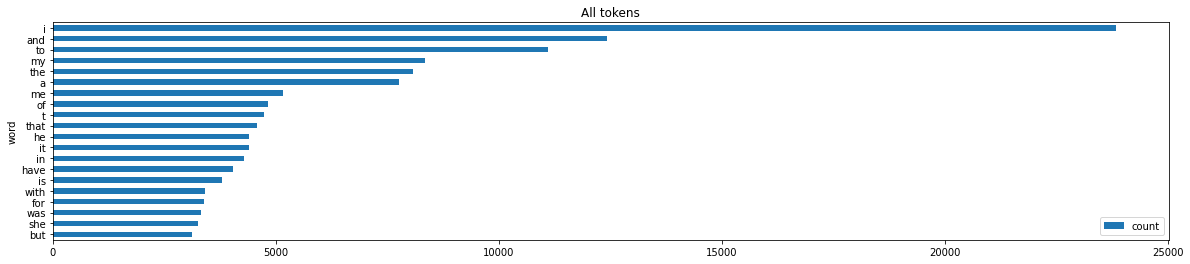

In [17]:
ldicts = count_dicts_from_texts(lexicon_tokenizer)
print(len(ldicts[2]))

# Display a general graph for all tokens
plot_dict(
    ldicts[2],
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)

In [18]:
# TODO explore the differences!


In [19]:
x = {"apple", "banana", "cherry"}
y = {"google", "microsoft", "apple"}

z = x.difference(y)
z

{'banana', 'cherry'}

In [20]:
r_specific = set(rdicts[2]).difference(set(fdicts[2]))
print(len(rdicts[2]),len(r_specific))
f_specific = set(fdicts[2]).difference(set(rdicts[2]))
print(len(fdicts[2]),len(f_specific))
g_specific = set(gdicts[2]).difference(set(rdicts[2]))
print(len(gdicts[2]),len(g_specific))
l_specific = set(ldicts[2]).difference(set(rdicts[2]))
print(len(ldicts[2]),len(l_specific))

9468 569
10937 2038
10938 2039
9109 1176


In [21]:
r_specific

{'0,2',
 '1,000',
 '1-2',
 '1-3',
 '1.5',
 '1.7',
 '10,000',
 '10-11',
 '10-14',
 '10-fold',
 '11-12',
 '12,and',
 '12-year',
 '14-19',
 '15-20',
 '16-year',
 '16-year-old',
 '17-year',
 '17-year-old',
 '18-20',
 '18-year-old',
 '19-year-old',
 '2-3',
 '2-4',
 '2-years-long',
 '2.5',
 '2.614',
 '20-28',
 '20-year-old',
 '200-800',
 '24-year-old',
 '24-yo',
 '24/7.am',
 '25-year-old',
 '27-year-old',
 '29-day',
 '3-4',
 '3-5',
 '3-5am',
 '3-6',
 '3.25',
 '3.5',
 '30-50',
 '33-year-old',
 '34-year-old',
 '4-5',
 '4-8',
 '4-year-old',
 '4.0',
 '5-10',
 '5-6',
 '5-year',
 '6-7',
 '6-7months',
 '63-year-old',
 '6x/week',
 '7,5,2',
 '7-9',
 '8-year-old',
 '80’s',
 '9,\xa0',
 '9-13yo',
 '9-month-old',
 '98%',
 'a-b',
 'a-student',
 'academics.\xa0',
 'accidental',
 'adrenaline-junkie',
 'africa',
 'ailment',
 'alarmed',
 'albania',
 'alcoholic.\xa0',
 'all-in-all',
 'all-star',
 'all-time',
 'allergies.\xa0',
 'allowed”to',
 'anemia',
 'angeles',
 'annually',
 'anorexia/bulimia',
 'antagonist

In [22]:
f_specific

{'“really?”',
 '(the',
 'wouldn’t)',
 'out)',
 'way…',
 'career)',
 'recently)',
 'kitchen”',
 'on?',
 '‘me’',
 'kids?',
 'of?',
 '“wrath”',
 'in)',
 'issue?',
 'doctors)',
 'gravity)',
 'distant;',
 ',\xa0he',
 'hospital?',
 '(of',
 '.please',
 'car…',
 'back?',
 '(we',
 'yet)',
 '(22',
 'everything;',
 'example:',
 'her)?',
 'sex:',
 'you!',
 'them)',
 'guilt)',
 'cent(really',
 'ish',
 '.\xa0',
 '21?',
 'package)',
 '(std’s',
 'why?',
 '(trichotillmania)',
 '‘vaughn’',
 '(frequent',
 'cut(or)kill',
 'parts”',
 '(deceased',
 '“the',
 '“consume',
 '1)',
 'states)',
 '(16)',
 'unstable”',
 'jyl)',
 'hello!',
 'attack”',
 'off…',
 '“prove',
 'arabia)',
 'right!',
 '“micro”',
 'i?',
 'intimacy!',
 "'i",
 'hospital)',
 '(hairclips',
 'ok?',
 'yourself”;',
 'inflicted',
 '“98%',
 'fiancé’',
 'kitchen!',
 'her!',
 'employer)',
 'phone!',
 '“searching',
 'pack',
 '(verbally',
 'note:',
 'daughter)',
 'home)',
 'nos',
 '18;',
 'worse…',
 'through)',
 'bio',
 'jail!',
 ',siblings)’s',
 '“hear'

In [23]:
g_specific

{'“really?”',
 '(the',
 'wouldn’t)',
 'out)',
 'way…',
 'career)',
 'recently)',
 'kitchen”',
 'on?',
 '‘me’',
 'kids?',
 'of?',
 '“wrath”',
 'in)',
 'issue?',
 'doctors)',
 'gravity)',
 'distant;',
 ',\xa0he',
 'hospital?',
 '(of',
 '.please',
 'car…',
 'back?',
 '(we',
 'yet)',
 '(22',
 'everything;',
 'example:',
 'her)?',
 'sex:',
 'you!',
 'them)',
 'guilt)',
 'cent(really',
 'ish',
 '.\xa0',
 '21?',
 'package)',
 '(std’s',
 'why?',
 '(trichotillmania)',
 '‘vaughn’',
 '(frequent',
 'cut(or)kill',
 'parts”',
 '(deceased',
 '“the',
 '“consume',
 '1)',
 'states)',
 '(16)',
 'unstable”',
 'jyl)',
 'hello!',
 'attack”',
 'off…',
 '“prove',
 'arabia)',
 'right!',
 '“micro”',
 'i?',
 'intimacy!',
 "'i",
 'hospital)',
 '(hairclips',
 'ok?',
 'yourself”;',
 'inflicted',
 '“98%',
 'fiancé’',
 'kitchen!',
 'her!',
 'employer)',
 'phone!',
 '“searching',
 'pack',
 '(verbally',
 'note:',
 'daughter)',
 'home)',
 'nos',
 '18;',
 'worse…',
 'through)',
 'bio',
 'jail!',
 ',siblings)’s',
 '“hear'

In [24]:
l_specific

{'scar',
 ', 32',
 '. 20',
 'osa',
 '.” (',
 'ally',
 'apa',
 'nl',
 'psychotics',
 'bari',
 'imm',
 '18 (',
 'wee',
 'survival',
 'sh',
 '2010.',
 'reo',
 'es',
 'oriented',
 'op',
 '18,',
 'soi',
 '5-',
 '5,',
 'visio',
 'dy',
 'odi',
 'inv',
 'jy',
 '10.',
 '41).',
 '13.',
 'ust',
 '!!!!',
 'warming',
 '10, 14, 15, & 19.',
 'ual',
 'ms',
 'loll',
 '22.',
 'compromised',
 'ol',
 '2015,',
 '].',
 '63-',
 ')?',
 'mies',
 'cupid',
 '. 4',
 '(22',
 '.: 2',
 'hen',
 'pico',
 '.” “',
 'fulness',
 '10 14 15 & 19',
 '58 – 66.',
 'traveler',
 'ï',
 'alc',
 'rien',
 'protectiveness',
 'gnat',
 'abs',
 'pian',
 '18-',
 '.   2',
 'aver',
 ').',
 'rec',
 'organo',
 '12,',
 'eh',
 'obs',
 'ish',
 '21?',
 'sud',
 'ble',
 'atta',
 'thl',
 'bing',
 'mac',
 'unica',
 '7 1/2',
 '. “',
 'oku',
 '…(',
 'ction',
 'craig',
 'pee',
 ', 10',
 'esta',
 'vigilant',
 '24/7,',
 'wouldn',
 'stant',
 'sp',
 'ppr',
 '(3',
 'ists',
 '1)',
 '(16)',
 'rag',
 '19 (',
 '-13',
 '”),',
 'hia',
 '(15)',
 'epi',
 '. 2)',
 '

In [27]:
#TODO keep checking rdicts[2] lexicon till no junk remaining
#TODO separate qoutes and apostrophes and split words on inword quotes

In [28]:
#TODO split in sentences!?